# 3.1-3.2 重要度重みと周辺重要度重みの大きさを比較

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')

from dataset import generate_synthetic_data, calc_true_value
from utils import eps_greedy_policy, calc_weights, aggregate_simulation_results

In [2]:
## シミュレーション設定
num_runs = 500 # シミュレーションの繰り返し回数
dim_context = 5 # # 特徴量xの次元
num_clusters = 30 # 行動クラスタ数
beta = -0.2 # データ収集方策のパラメータ
num_data = 2000 # ログデータのサイズ
random_state = 12345
lambda_ = 0.0 # クラスタ効果と残差効果の配合率
num_actions_list = [100, 250, 500, 1000, 2000, 4000] # 行動数, |A|

In [3]:
result_df_list = []
for num_actions in num_actions_list:
    random_ = check_random_state(random_state)
    phi_a = random_.choice(num_clusters, size=num_actions)
    theta_g = random_.normal(size=(dim_context, num_clusters))
    M_g = random_.normal(size=(dim_context, num_clusters))
    b_g = random_.normal(size=(1, num_clusters))
    theta_h = random_.normal(size=(dim_context, num_actions))
    M_h = random_.normal(size=(dim_context, num_actions))
    b_h = random_.normal(size=(1, num_actions))

    for _ in tqdm(range(num_runs), desc=f"num_actions={num_actions}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, lambda_=lambda_, beta=beta,
            theta_g=theta_g, M_g=M_g, b_g=b_g,
            theta_h=theta_h, M_h=M_h, b_h=b_h, phi_a=phi_a,
            dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters,
            random_state = _
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["q_x_a"])

        ## シミュレーション結果の集計
        w_x_a, w_x_c = calc_weights(offline_logged_data, pi)
        result_df = DataFrame(
            [num_actions, w_x_a.max(), w_x_c.max()],
            index=["num_actions", "max_iw", "max_miw"]
        )
        result_df_list.append(result_df.T)
result_df = pd.concat(result_df_list).reset_index(level=0)
result_df_ = result_df.groupby(["num_actions"]).mean()

num_actions=100...:   0%|          | 0/500 [00:00<?, ?it/s]

num_actions=4000...: 100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


## 図3.2

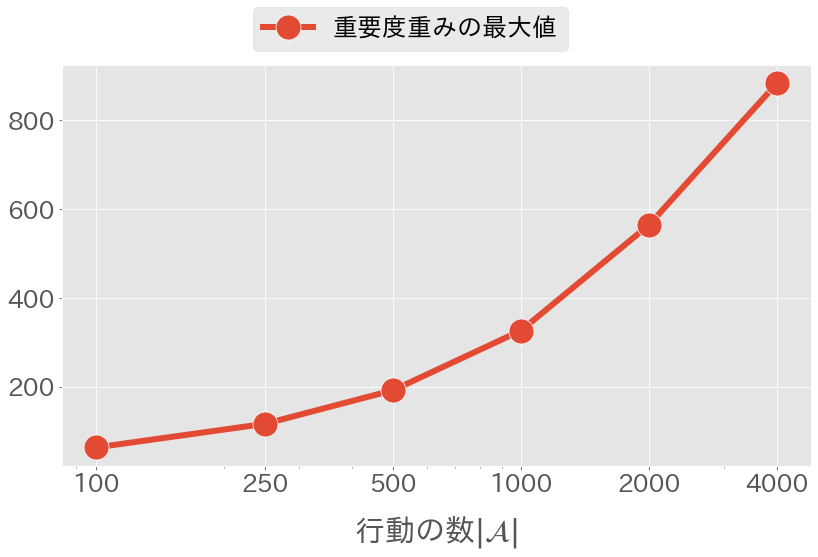

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(11.5, 7), tight_layout=True)
for y in ["max_iw"]:
    sns.lineplot(
        markers=True,
        markersize=25,
        linewidth=6,
        legend=False,
        style="index",
        x="num_actions",
        y=y,
        ax=ax,
        data=result_df_,
    )
# yaxis
ax.set_ylabel("")
ax.tick_params(axis="y", labelsize=25)
ax.yaxis.set_label_coords(-0.1, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel(r"行動の数$|\mathcal{A}|$", fontsize=30)
ax.set_xticks(num_actions_list)
ax.set_xticklabels(num_actions_list, fontsize=25)
ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["重要度重みの最大値"], fontsize=25, bbox_to_anchor=(0.5, 1.05), ncol=4, loc="center")

## 図3.6

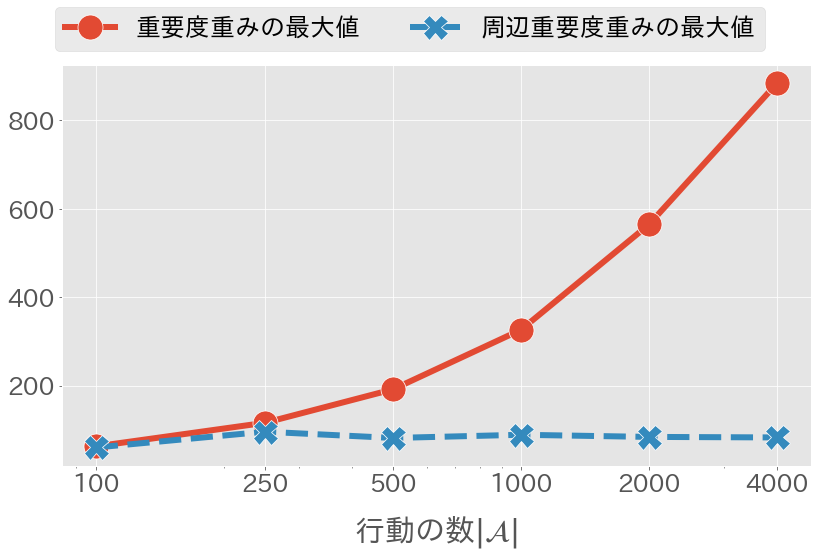

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(11.5, 7), tight_layout=True)
for y in ["max_iw", "max_miw"]:
    if y == "max_miw":
        marker = "X"
        line = "--"
    else:
        marker = "o"
        line = "-"
    sns.lineplot(
        markersize=25,
        marker=marker,
        linestyle=line,
        linewidth=6,
        legend=False,
        x="num_actions",
        y=y,
        ax=ax,
        data=result_df_,
    )
# yaxis
ax.set_ylabel("")
ax.tick_params(axis="y", labelsize=25)
ax.yaxis.set_label_coords(-0.1, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel(r"行動の数$|\mathcal{A}|$", fontsize=30)
ax.set_xticks(num_actions_list)
ax.set_xticklabels(num_actions_list, fontsize=25)
ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["重要度重みの最大値", "周辺重要度重みの最大値"],
    fontsize=25, bbox_to_anchor=(0.5, 1.05), ncol=4, loc="center",
)